In [35]:
from nilearn import image, input_data, masking, plotting, signal
from nilearn.datasets import MNI152_FILE_PATH
from nilearn.plotting import plot_roi, plot_epi, show
import numpy as np
import matplotlib.pylab as plt
from scipy.fftpack import rfftfreq, rfft
from scipy.signal import detrend, 
from scipy.stats import zscore
import pandas as pd
%matplotlib inline

In [2]:
nifti_path = "/home/maciek/datasets/braindyn_bids/derivatives/fmriprep/sub-106/func/sub-106_task-flicker_dir-AP_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
brain_mask_path = "/home/maciek/datasets/braindyn_bids/derivatives/fmriprep/sub-106/func/sub-106_task-flicker_dir-AP_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
specific_mask = "/home/maciek/git/BrainDyn_ANALYSIS/masks/hocp-Occipital_Fusiform_Gyrus.nii.gz"
t1_path = "/home/maciek/datasets/braindyn_bids/derivatives/fmriprep/sub-106/anat/sub-106_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
confounds_path = None

from: gao 2018

### GLOBAL
* spatial smoothing FWHM 3mm

### FOR EACH VOXEL
* removal of a linear trend
* divide the timeseries by the mean intensity (but use a robust normalisation)
* FFT of the time series
* z-score the amplitude (equivalent of the SNR)
* SNR

In [3]:
flicker = image.smooth_img(nifti_path, fwhm=None)

In [4]:
ffg_mask = image.smooth_img(specific_mask, fwhm=None)
ffg_mask = image.resample_to_img(ffg_mask, flicker, fill_value=0, clip=True, interpolation="nearest")

### Harvard-Oxford Probabilistic Atlas: Mask of Fusiform Gyrus thresholded at 15%

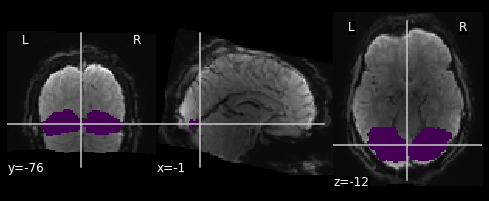

In [5]:
plotting.plot_img(ffg_mask, threshold=.9999, bg_img=image.mean_img(flicker), black_bg=True);

### Mean Flicker fMRI

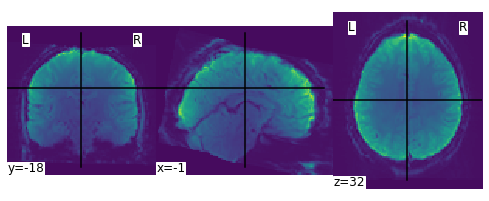

In [6]:
plotting.plot_img(image.mean_img(flicker));

#### EXTRACTION OF THE TIME SERIES WITHIN MASK + SMOOTHING
* the time series are extracted and transformed into samples (time) x features (voxel)

In [7]:
flicker_masked = masking.apply_mask(flicker, ffg_mask, smoothing_fwhm=3)

In [8]:
random_voxels = [2967, 1254, 4043, 5285, 8838]
random_voxels.sort()

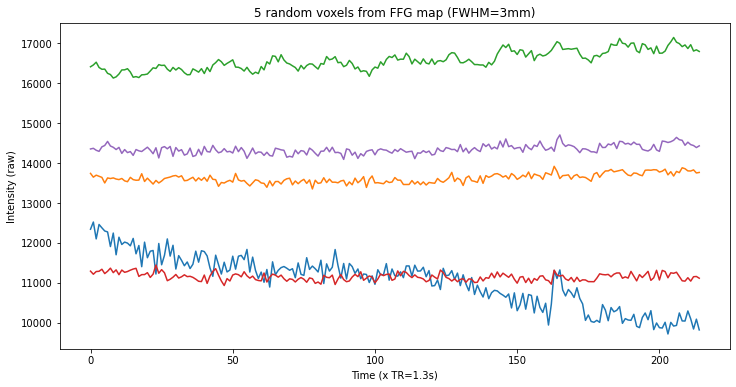

In [61]:
# selected 5 voxels, transposed to voxel x time
data = flicker_masked[:, random_voxels] 
f, ax = plt.subplots(figsize=(12,6))
plt.set_cmap("tab10")
plt.plot(data)
plt.title("5 random voxels from FFG map (FWHM=3mm)")
plt.ylabel("Intensity (raw)")
plt.xlabel("Time (x TR=1.3s)");

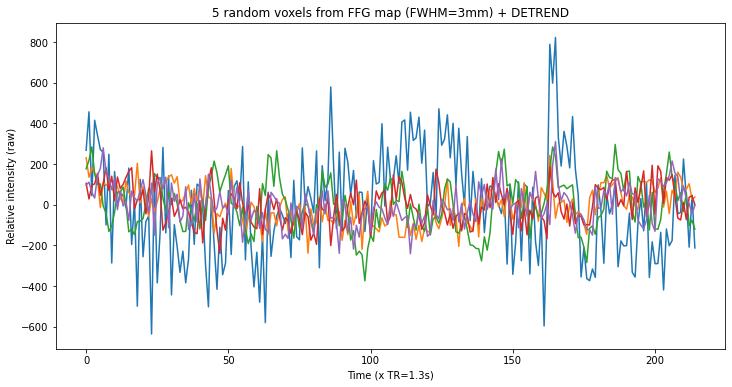

In [100]:
# selected 5 voxels, transposed to voxel x time + DETREND
data = flicker_masked[:, random_voxels]
data = signal._detrend(data, type="linear") # -= mean + linear trend removed
f, ax = plt.subplots(figsize=(12,6))
plt.set_cmap("tab10")
plt.plot(data)
plt.title("5 random voxels from FFG map (FWHM=3mm) + DETREND")
plt.ylabel("Relative intensity (raw)")
plt.xlabel("Time (x TR=1.3s)");

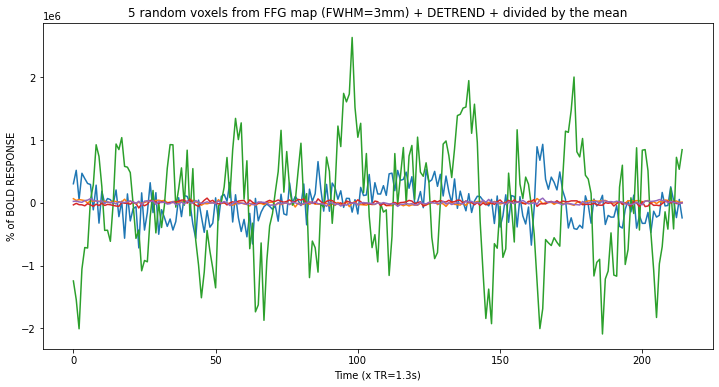

In [101]:
data = flicker_masked[:, random_voxels]
data = signal.clean(data, standardize=False, detrend=True)
data = np.divide(data, np.mean(data, axis=0).transpose())
f, ax = plt.subplots(figsize=(12,6))
plt.set_cmap("tab10")
plt.plot(data)
plt.title("5 random voxels from FFG map (FWHM=3mm) + DETREND + divided by the mean")
plt.ylabel("% of BOLD RESPONSE")
plt.xlabel("Time (x TR=1.3s)");

''

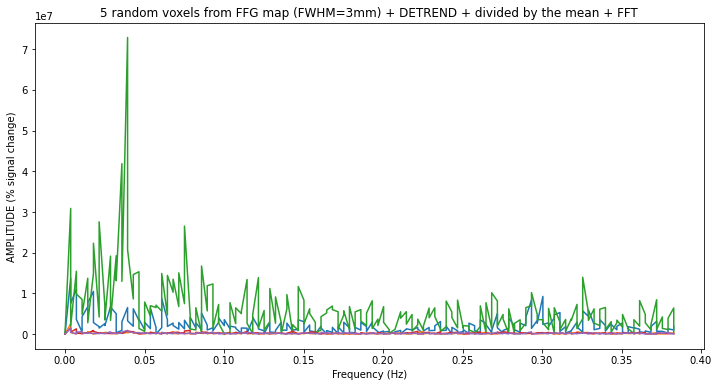

In [103]:
# selected 5 voxels, transposed to voxel x time + DETREND
# realFFT
# without zscore looks like from gao 2018 
data = flicker_masked[:, random_voxels]
data = signal.clean(data, standardize=False, detrend=True)
data = np.divide(data, np.mean(data, axis=0).transpose())
fft_Y = rfft(data, axis=0)
fft_FREQ = rfftfreq(fft_Y.shape[0], 1.3)
f, ax = plt.subplots(figsize=(12,6))
plt.set_cmap("tab10")
plt.plot(fft_FREQ, np.abs(fft_Y))
plt.title("5 random voxels from FFG map (FWHM=3mm) + DETREND + divided by the mean + FFT")
plt.ylabel("AMPLITUDE (% signal change)")
plt.xlabel("Frequency (Hz)")
;